<a href="https://colab.research.google.com/github/zhukuixi/Kaggle/blob/main/Adversarial_Validation_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

train_clinical_data["origin"] = 0
supplemental_clinical_data["origin"] = 1

combined = pd.concat([train_clinical_data, supplemental_clinical_data]).reset_index(drop=True)

features = [
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication',
]

le = LabelEncoder()
combined['upd23b_clinical_state_on_medication'] = le.fit_transform(combined['upd23b_clinical_state_on_medication'])
    
n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

confusion = confusion_matrix(combined["origin"], train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

labels = ["Clincial Data", "Supplemental Data"]

_ = sns.heatmap(confusion, annot=True, fmt=",d", ax=axs[0], xticklabels=labels, yticklabels=labels)
_ = axs[0].set_title("Confusion Matrix (@ 0.5 Probability)", fontsize=15)
_ = axs[0].set_ylabel("Actual Class")
_ = axs[0].set_xlabel("Predicted Class")

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
_ = sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
_ = axs[1].set_title("ROC Curve", fontsize=15)
_ = axs[1].set_xlabel("False Positive Rate")
_ = axs[1].set_ylabel("True Positive Rate")



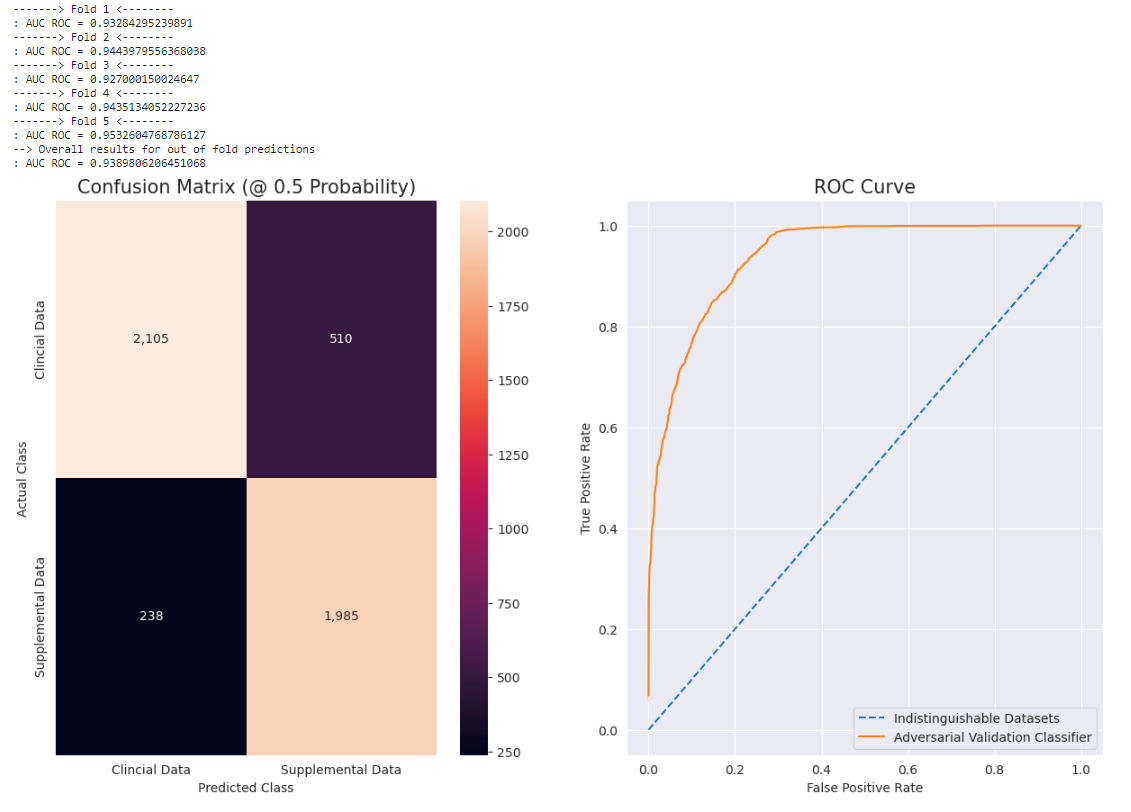